In [1]:
import numpy as np
import time
from jax import random, jit, vmap
from jax import numpy as jnp
import matplotlib.pyplot as plt
from data import get_signal, get_samples
from utils import relative_error, align_to_signal
from mca import mca
from bsi import bsi
from em import em


def run_many(M):
    def decorator(func):
        def wrapper(key, *args, **kwargs):
            keys = random.split(key, M)
            vals = func(keys[0], *args, **kwargs)
            ret = tuple([v,] for v in vals) 
            for m in range(1, M):
                vals = func(keys[m], *args, **kwargs)
                for r, v in zip(ret, vals):
                    r.append(v)
            return ret
        return wrapper
    return decorator


@run_many(20)
def run_method(key, x, std, N, method, **kwargs):
    y, noise, shift = get_samples(key, x, std, N)
    
    @jit
    def oracle(y, std, shift): 
        return vmap(jnp.roll, (0, 0))(y, -shift).mean(axis=0)
    
    if method == "oracle":
        kwargs["shift"] = shift
        method = oracle
    
    t = time.time()
    error = relative_error(x, align_to_signal(method(y, std, **kwargs), x))
    t = time.time() - t
    return error, t


L = 41
N = int(1e4)
t, x = get_signal(L)
stds = jnp.logspace(-2, 1.0, 20)
keys = random.split(random.PRNGKey(0), len(stds))
x0 = random.normal(keys[0], (L,))

methods = ("oracle", mca, bsi, em)
names = ("Oracle", "MCA", "BSI", "EM")
kwargs_vec = ({}, {"x0": x0}, {}, {"x0":x0})
data = {name: None for name in names}


for method, name, kwargs in zip(methods, names, kwargs_vec):
    errors = []
    times = []
    for i, (std, k) in enumerate(zip(stds, keys)):
        e, t = run_method(k, x, std, N, method, **kwargs)
        errors.append(e)
        times.append(t)
        print(f'RUN: std={std}, total {i+1}/{len(stds)} steps')
    data[name] = (stds, errors, times)

I0000 00:00:1725815450.776903   74824 tfrt_cpu_pjrt_client.cc:349] TfrtCpuClient created.
No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


RUN: std=0.009999999776482582, total 1/20 steps
RUN: std=0.014384498819708824, total 2/20 steps
RUN: std=0.02069137990474701, total 3/20 steps
RUN: std=0.029763512313365936, total 4/20 steps
RUN: std=0.04281333461403847, total 5/20 steps
RUN: std=0.06158483400940895, total 6/20 steps
RUN: std=0.08858667314052582, total 7/20 steps
RUN: std=0.12742751836776733, total 8/20 steps
RUN: std=0.18329808115959167, total 9/20 steps
RUN: std=0.2636650502681732, total 10/20 steps
RUN: std=0.3792690634727478, total 11/20 steps
RUN: std=0.5455594658851624, total 12/20 steps
RUN: std=0.7847599387168884, total 13/20 steps
RUN: std=1.1288379430770874, total 14/20 steps
RUN: std=1.6237766742706299, total 15/20 steps
RUN: std=2.335721492767334, total 16/20 steps
RUN: std=3.359818458557129, total 17/20 steps
RUN: std=4.832930564880371, total 18/20 steps
RUN: std=6.95192813873291, total 19/20 steps
RUN: std=10.0, total 20/20 steps
RUN: std=0.009999999776482582, total 1/20 steps
RUN: std=0.01438449881970882

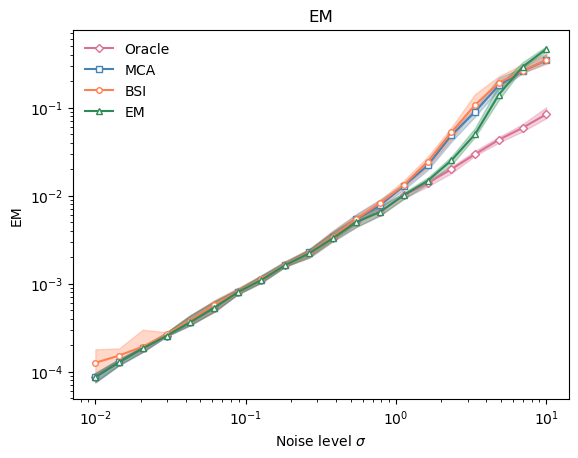

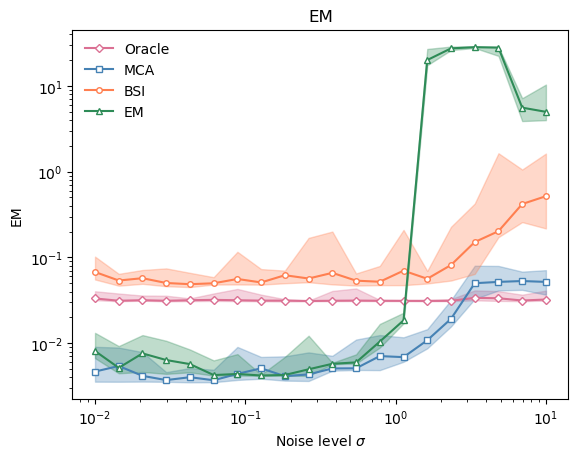

In [7]:
colors = ["palevioletred", "steelblue", "coral", "seagreen", "indianred", "olivedrab"]
styles = ["-D", "-s", "-o", "-^", "-v", "+"]
    
alpha = 0.2
for j, name in enumerate(['Normalized MSE', 'Computation time']):
    idx = 0
    fig = plt.figure()
    for i, (name, method) in enumerate(zip(names, methods)):
        method_data = data[name]
        stds = method_data[0]
        err_vec = np.array(method_data[j+1])
        
        err_sort = np.sort(err_vec, axis=1)
        err_max = err_sort[:, int((1-alpha) * err_sort.shape[1])]
        err_min = err_sort[:, int(alpha * err_sort.shape[1])]
        err_mean = np.median(err_vec, axis=1)    
            
        plt.plot(stds, err_mean, styles[idx], color=colors[idx], label=name, markersize=4, markerfacecolor='white')
        plt.fill_between(stds, err_max, err_min, color=colors[idx], alpha=0.3)
            
        idx += 1
    plt.legend(frameon=False)
    plt.title(name)
    plt.ylabel(name)
    plt.xlabel("Noise level $\sigma$")
    plt.xscale('log')
    plt.yscale('log')